In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Project - London Properties").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/01/06 22:23:21 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/06 22:23:21 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/06 22:23:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Read data

In [ ]:
df_orders = spark.read.option("header", "true").option("inferschema", "true").csv("hdfs://localhost:8020/user/matuszewskis/project/PricePaidData/orders_2023-12-04_11-13-47.csv")
df_stores = spark.read.option("header", "true").option("inferschema", "true").csv("hdfs://localhost:8020/user/matuszewskis/reference/stores.csv")
df_channels = spark.read.option("header", "true").option("inferschema", "true").csv("hdfs://localhost:8020/user/matuszewskis/reference/channels.csv")
print('Loading completed.')

In [95]:
hadoop_directiory_path_PricePaidData = "hdfs://localhost:8020/user/matuszewskis/project/PricePaidData/*.csv"

df_ppd = spark.read.option("header", "true").option("inferschema", "true").csv(hadoop_directiory_path_PricePaidData)

In [96]:
hadoop_directiory_path_LDD = "hdfs://localhost:8020/user/matuszewskis/project/LDD/*.csv"

df_ldd = spark.read.option("header", "true").option("inferschema", "true").csv(hadoop_directiory_path_LDD)

### Simple and quick EDA

In [9]:
from functools import reduce

In [97]:
df_ppd.count()

5143200

In [98]:
df_ldd.count()

70319

In [99]:
df_ppd.show()

+------+------------+--------------------+-------------+--------------+------------------+--------------------+----------+----------+--------+
| Price|        City|             Borough|       County|      District|            Street|              Number|Appartment|PostalCode|DateOnly|
+------+------------+--------------------+-------------+--------------+------------------+--------------------+----------+----------+--------+
| 89950|  NOTTINGHAM|             EREWASH|   DERBYSHIRE|    LONG EATON|    STATION STREET|NEW CENTRAL BUILD...|    FLAT 1|  NG10 1GL|29012016|
|224950|CHESTERFIELD|        CHESTERFIELD|   DERBYSHIRE|          null|    STEEPLE GRANGE|                  10|      null|   S41 0HU|29012016|
|192000|CHESTERFIELD|            BOLSOVER|   DERBYSHIRE|      BOLSOVER|   PARK VIEW CLOSE|                   1|      null|   S44 6FN| 5022016|
|149950| SWADLINCOTE|    SOUTH DERBYSHIRE|   DERBYSHIRE|        MIDWAY|      SAMARA CLOSE|                   9|      null|  DE11 0FJ|22012016|

In [100]:
df_ldd.show()

+---------+-------------------+-----------------+--------------+--------------------+----------------------------+---------------------------------+---------------+------------+--------------+--------------------+--------+
|Post Code|Primary Street Name|Permission Status|No of Bedrooms|           Unit Type|Residential Development Type|Building height (maximum storeys)|Superseded date|Started Date|Completed date|             Borough|DateOnly|
+---------+-------------------+-----------------+--------------+--------------------+----------------------------+---------------------------------+---------------+------------+--------------+--------------------+--------+
| RM10 8EB|          Reede Way|       Superseded|           1.0|Flat Apartment or...|        New Residential B...|                              2.0|           null|        null|          null|Barking and Dagenham| 5022015|
| RM10 8EB|          Reede Way|       Superseded|           2.0|Flat Apartment or...|        New Residential

### Preparing aggregated data for visualisations

In [180]:
from pyspark.sql.functions import col, year, month, substring, expr, upper, mean, regexp_replace

In [101]:
df_ppd = df_ppd.filter(col("City") == "LONDON")

In [102]:
df_ldd = df_ldd.withColumn("Year", substring(col("DateOnly"), -4, 4).cast("int"))
df_ppd = df_ppd.withColumn("Year", substring(col("DateOnly"), -4, 4).cast("int"))

In [103]:
df_ldd = df_ldd.withColumn("Month", expr("substring(DateOnly, length(DateOnly)-5, 2)").cast("int"))
df_ppd = df_ppd.withColumn("Month", expr("substring(DateOnly, length(DateOnly)-5, 2)").cast("int"))

In [104]:
df_ldd = df_ldd.withColumn("Day", expr("substring(DateOnly, 1, length(DateOnly)-6)").cast("int"))
df_ppd = df_ppd.withColumn("Day", expr("substring(DateOnly, 1, length(DateOnly)-6)").cast("int"))

In [105]:
df_ldd = df_ldd.withColumn("Borough", upper(col("Borough")))

In [106]:
numeric_columns_ldd = [col_name for col_name, col_type in df_ldd.dtypes if col_type in ['double', 'int']][:-4]
numeric_columns_ppd = [col_name for col_name, col_type in df_ppd.dtypes if col_type in ['double', 'int']][:-4]

In [107]:
df_ldd = df_ldd.na.drop(subset=numeric_columns_ldd)
df_ppd = df_ppd.na.drop(subset=numeric_columns_ppd)

In [108]:
df_ldd_mean_by = df_ldd.groupBy("Borough", "Year").agg(*(mean(col_name).alias(f"Mean_{col_name}") for col_name in numeric_columns_ldd))
df_ppd_mean_by = df_ppd.groupBy("Borough", "Year").agg(*(mean(col_name).alias(f"Mean_{col_name}") for col_name in numeric_columns_ppd))
df_ldd_mean_ym = df_ldd.groupBy("Year", "Month").agg(*(mean(col_name).alias(f"Mean_{col_name}") for col_name in numeric_columns_ldd))
df_ppd_mean_ym = df_ppd.groupBy("Year", "Month").agg(*(mean(col_name).alias(f"Mean_{col_name}") for col_name in numeric_columns_ppd))

In [187]:
merged_by = df_ldd_mean_by.join(df_ppd_mean_by, ['Borough', 'Year'], 'left')
merged_ym = df_ldd_mean_ym.join(df_ppd_mean_ym, ['Year', 'Month'], 'left')

In [188]:
for col_name in merged_ym.columns:
    merged_ym = merged_ym.withColumnRenamed(col_name, col_name.replace(" ", "_").replace("(", "").replace(")", ""))
for col_name in merged_by.columns:
    merged_by = merged_by.withColumnRenamed(col_name, col_name.replace(" ", "_").replace("(", "").replace(")", ""))

In [189]:
merged_ym.show()

+----+-----+-------------------+------------------------------------+------------------+
|Year|Month|Mean_No_of_Bedrooms|Mean_Building_height_maximum_storeys|        Mean_Price|
+----+-----+-------------------+------------------------------------+------------------+
|2015|    2| 2.2650602409638556|                   26.25602409638554| 729797.3082631368|
|2017|    3|  2.264646464646465|                   8.424242424242424| 953463.0840964591|
|2017|    8| 2.1725888324873095|                   7.535532994923858| 864724.8906580016|
|2014|    4|  2.209621993127148|                  12.958762886597938|  710839.173211237|
|2017|   10|  2.155313351498638|                   7.021798365122616| 964845.0763555251|
|2018|   10|  2.175480769230769|                   6.211538461538462| 898489.1211807354|
|2015|   12| 2.1358885017421603|                   11.80836236933798| 928461.7741384221|
|2016|    7|  2.235135135135135|                   6.094594594594595| 764402.6407185629|
|2016|   11| 2.211790

In [190]:
merged_by.show()

+--------------------+----+-------------------+------------------------------------+------------------+
|             Borough|Year|Mean_No_of_Bedrooms|Mean_Building_height_maximum_storeys|        Mean_Price|
+--------------------+----+-------------------+------------------------------------+------------------+
|             ENFIELD|2014|   2.27027027027027|                  14.243243243243244|     377910.940625|
|          HILLINGDON|2017|  2.314814814814815|                   7.111111111111111|          495000.0|
|              MERTON|2017|              2.375|                   4.086538461538462| 836466.2555066079|
|         WESTMINSTER|2018|  2.207692307692308|                   8.138461538461538|              null|
|             LAMBETH|2015|                2.0|                            31.44375| 604497.8282076395|
|            HOUNSLOW|2016| 1.9426229508196722|                   7.475409836065574| 973610.5623762376|
|             BROMLEY|2018| 2.2142857142857144|                 

### Writing batch views

In [191]:
merged_ym.write.parquet('hdfs://localhost:8020/user/matuszewskis/project/PricePaidData/merged_year_month.parquet')
merged_by.write.parquet('hdfs://localhost:8020/user/matuszewskis/project/PricePaidData/merged_borough_year.parquet')

### Visualisations

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Plot 1.

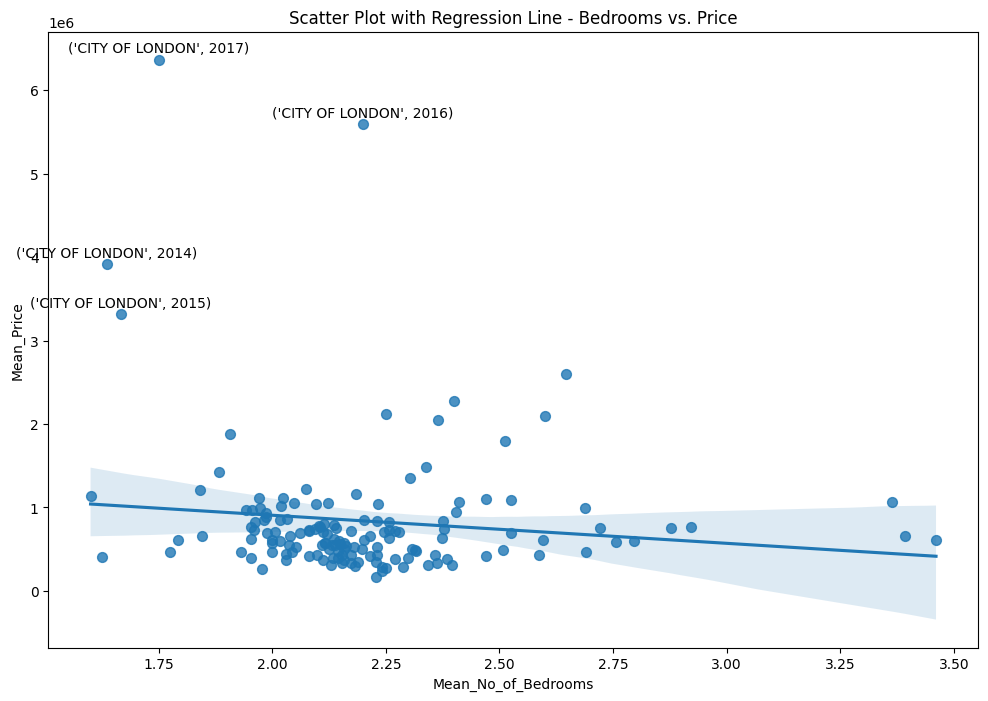

In [193]:
merged_by_pd = merged_by.toPandas()

plt.figure(figsize=(12, 8))
sns.regplot(x='Mean_No_of_Bedrooms', y='Mean_Price', data=merged_by_pd, scatter_kws={'s':50})
z_scores = ((merged_by_pd['Mean_Price'] - merged_by_pd['Mean_Price'].mean()) / merged_by_pd['Mean_Price'].std()).abs()
outliers = merged_by_pd[z_scores > 3]

for i, row in outliers.iterrows():
    plt.annotate((row['Borough'], row['Year']), (row['Mean_No_of_Bedrooms'], row['Mean_Price']), textcoords="offset points", xytext=(0,5), ha='center')
plt.title('Scatter Plot with Regression Line - Bedrooms vs. Price')
plt.savefig('bedrooms_vs_price_by.png')
plt.show()

### Plot 2.

<Figure size 1200x800 with 0 Axes>

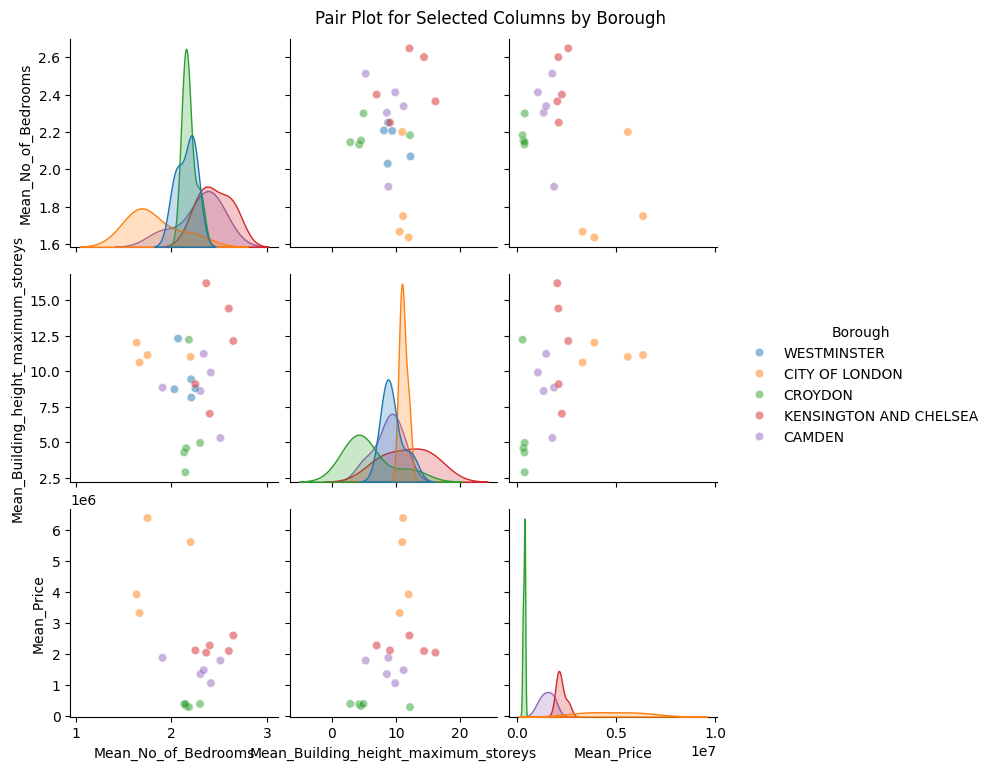

In [194]:
selected_columns = ['Mean_No_of_Bedrooms', 'Mean_Building_height_maximum_storeys', 'Mean_Price']
pair_plot_data = merged_by_pd[selected_columns + ['Borough']]
pair_plot_data = pair_plot_data[pair_plot_data['Borough'].isin(['CAMDEN', 'CITY OF LONDON', 'CROYDON', 'KENSINGTON AND CHELSEA', 'WESTMINSTER'])]
plt.figure(figsize=(12, 8))
sns.pairplot(pair_plot_data, hue='Borough', plot_kws={'alpha':0.5})
plt.suptitle('Pair Plot for Selected Columns by Borough', y=1.02)
plt.savefig('pair_plot_by.png')
plt.show()

### Plot 3.

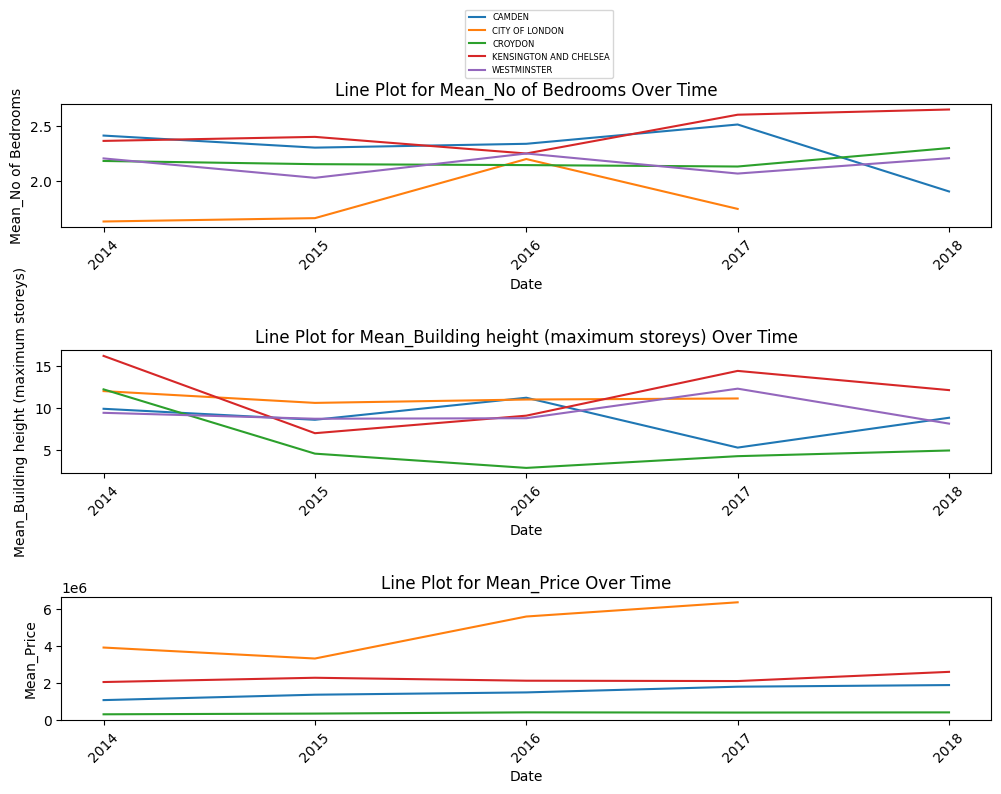

In [178]:
# merged_by_pd['Month-Year'] = merged_by_pd['Year'].astype(str) + '-' + merged_by_pd['Month'].astype(str).str.zfill(2)
time_series_columns = selected_columns
i = 1
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=1.0)
for col_name in time_series_columns:
    plt.subplot(3, 1, i)
    years = sorted(merged_by_pd['Year'].unique())
    for borough in ['CAMDEN', 'CITY OF LONDON', 'CROYDON', 'KENSINGTON AND CHELSEA', 'WESTMINSTER']:
        borough_data = merged_by_pd[merged_by_pd['Borough'] == borough].sort_values(by=['Year']).reset_index(drop=True)
        plt.plot(borough_data['Year'], borough_data[col_name], label=f'{borough}')
        plt.title(f'Line Plot for {col_name} Over Time')
        plt.xlabel('Date')
        plt.ylabel(f'{col_name}')
        plt.xticks(years, rotation=45)
        if i == 1:
            plt.legend(bbox_to_anchor=(0.43,1.8), loc='upper left', fontsize='6')
    i += 1
plt.savefig('timeseries_by.png')
plt.show()

### Plot 4.

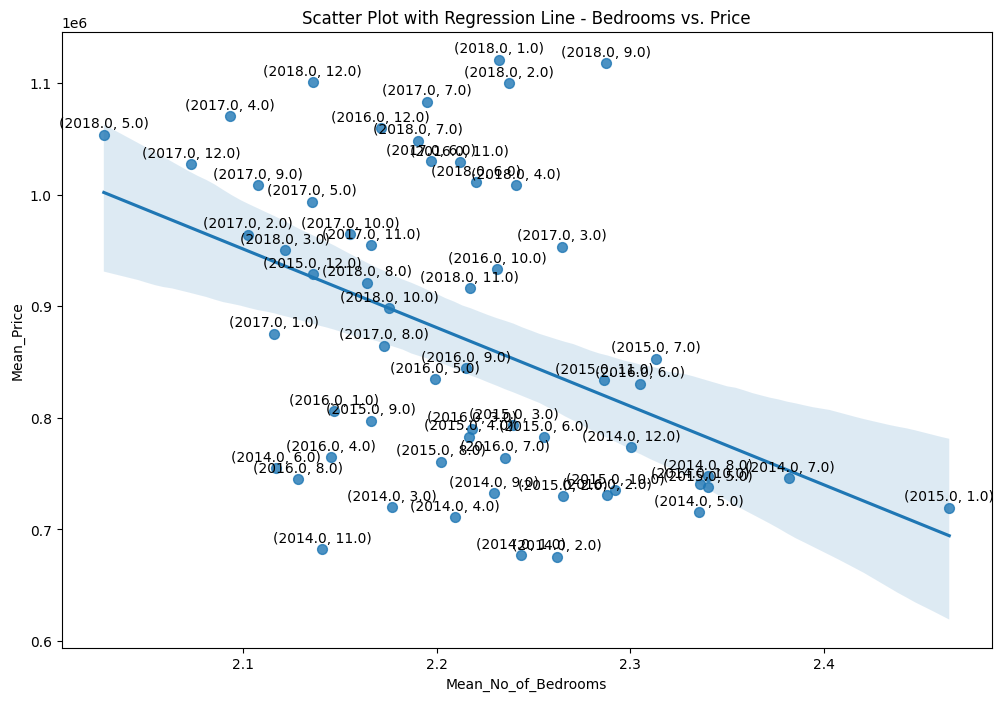

In [195]:
merged_ym_pd = merged_ym.toPandas()

plt.figure(figsize=(12, 8))
sns.regplot(x='Mean_No_of_Bedrooms', y='Mean_Price', data=merged_ym_pd, scatter_kws={'s':50})
# plt.annotate((row['Year'], row['Month']), (row['Mean_No of Bedrooms'], row['Mean_Price']), textcoords="offset points", xytext=(0,5), ha='center')
# z_scores = ((merged_ym_pd['Mean_Price'] - merged_ym_pd['Mean_Price'].mean()) / merged_ym_pd['Mean_Price'].std()).abs()
# outliers = merged_ym_pd[z_scores > 3]

for i, row in merged_ym_pd.iterrows():
    plt.annotate((row['Year'], row['Month']), (row['Mean_No_of_Bedrooms'], row['Mean_Price']), textcoords="offset points", xytext=(0,5), ha='center')
plt.title('Scatter Plot with Regression Line - Bedrooms vs. Price')
plt.savefig('bedrooms_vs_price_ym.png')
plt.show()

### Plot 5.

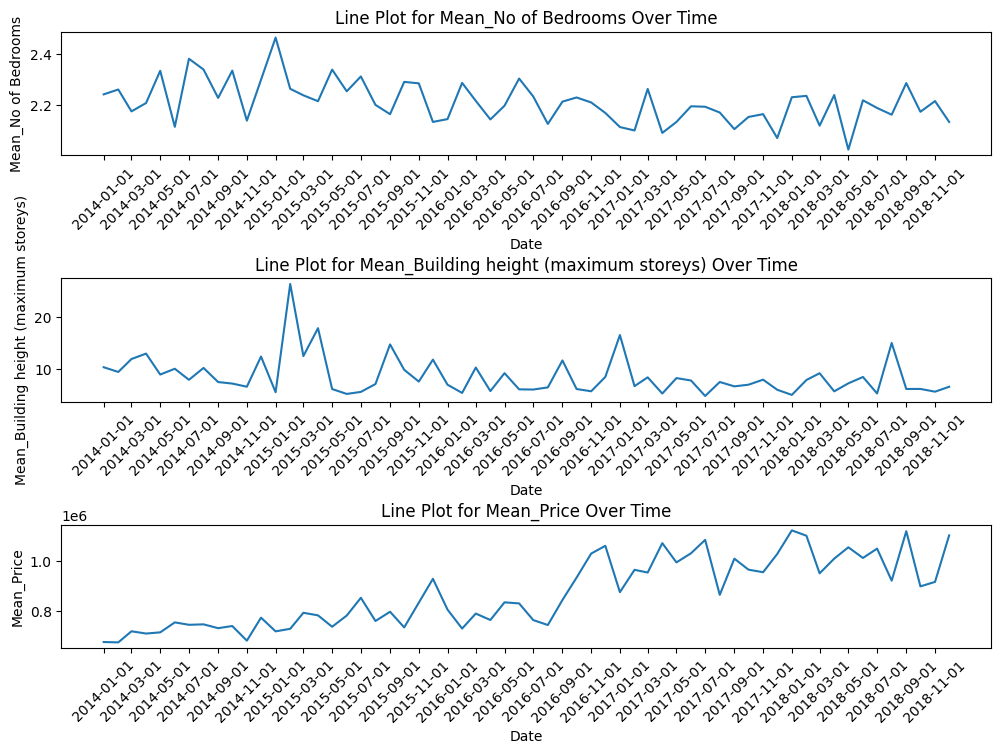

In [160]:
from datetime import datetime
time_series_columns = selected_columns
i = 1
merged_ym_pd['Month-Year'] = merged_ym_pd['Year'].astype(str) + '-' + merged_ym_pd['Month'].astype(str).str.zfill(2)
plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=1.0)
dates = merged_ym_pd['Month-Year'].unique()
date_objects = [datetime.strptime(date_str, '%Y-%m') for date_str in dates]
sorted_dates = sorted(date_objects)
sorted_date_strings = [date.strftime('%Y-%m') for date in sorted_dates]
merged_ym_pd['Month-Year'] = pd.to_datetime(merged_ym_pd['Month-Year'], format='%Y-%m')
sorted_ym_pd = merged_ym_pd.sort_values(by='Month-Year')
for col_name in time_series_columns:
    plt.subplot(3, 1, i)
    plt.plot(sorted_ym_pd['Month-Year'], sorted_ym_pd[col_name])
    plt.title(f'Line Plot for {col_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{col_name}')
    plt.xticks(sorted_date_strings[::2], rotation=45)
    # if i == 1:
    #     plt.legend(bbox_to_anchor=(0.35,1.8), loc='upper left')
    i += 1
plt.savefig('timeseries_ym.png')
plt.show()